# Task Performance Comparison

In [1]:
%load_ext autoreload
%autoreload 2

import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

from htc.context.models.context_evaluation import best_run_data
from htc.context.settings_context import settings_context
from htc.settings_seg import settings_seg

pio.kaleido.scope.mathjax = None

In [2]:
df = best_run_data(test=True)
df

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:510
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_model_comparison                 

[WARNING][py.warnings] /home/j562r/htc/src/htc/context/models/context_evaluation.py:44: FutureWarning:   warnings.py:109
                                                                                                                        
The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version                 
of pandas, the provided callable will be used directly. To keep current behavior pass the string "min"                  
instead.                                                                                                                
                                                                                                                        
                                                                                                                        

[INFO][htc.no_duplicates] Found pretrained run in the local results dir at                               HTCModel.py:510
/mnt/ssd_8tb/htc/results_semantic/training/image/2022-02-03_22-58-44_generated_default_rgb_model_compari                
son                                                                                                                     

,network,dataset,label_index,dice_metric,surface_distance_metric,surface_dice_metric_mean,label_name,modality
0,baseline,semantic,6,0.861474,9.262870,0.790171,stomach,HSI
1,baseline,semantic,5,0.957207,4.624576,0.791536,small_bowel,HSI
2,baseline,semantic,4,0.948589,3.187332,0.924161,colon,HSI
3,baseline,semantic,3,0.955587,3.820706,0.645928,liver,HSI
4,baseline,semantic,8,0.812361,2.863776,0.494350,gallbladder,HSI
...,...,...,...,...,...,...,...,...
14,organ_transplantation,glove,15,0.922216,6.793903,0.630940,muscle,RGB
15,organ_transplantation,glove,11,0.554482,69.735535,0.597443,peritoneum,RGB
16,organ_transplantation,glove,17,0.846557,4.342079,0.900535,major_vein,RGB
17,organ_transplantation,glove,18,0.884892,4.637167,0.469302,kidney_with_Gerotas_fascia,RGB


## Dataset Comparison

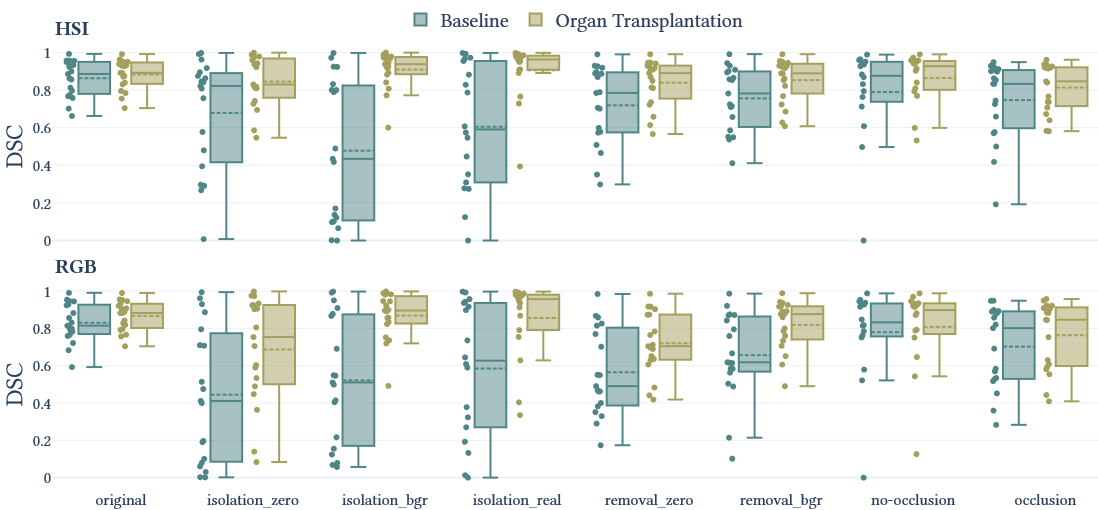

In [3]:
def dataset_comparison(metric_name: str) -> go.Figure:
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=["<b>HSI</b>", "<b>RGB</b>"],
        shared_xaxes=True,
        vertical_spacing=0.07,
    )

    network_renaming = {
        "baseline": "Baseline",
        "organ_transplantation": "Organ Transplantation",
    }

    def add_modality(modality: str, row: int, col: int) -> go.Figure:
        df_m = df.query("modality == @modality")
        for dataset, dataset_name in settings_context.task_name_mapping.items():
            for network in df_m["network"].unique():
                df_box = df_m.query("dataset == @dataset and network == @network")
                fig.add_trace(
                    go.Box(
                        y=df_box[metric_name],
                        x=[dataset_name] * len(df_box[metric_name]),
                        offsetgroup=network,
                        text=df_box["label_name"],
                        boxpoints="all",
                        boxmean=True,
                        name=network_renaming.get(network, network),
                        marker_color=settings_context.network_colors[network],
                        legendgroup=network,
                        showlegend=row == 1 and col == 1 and dataset == "semantic",
                    ),
                    row=row,
                    col=col,
                )

        return fig

    add_modality("HSI", row=1, col=1)
    add_modality("RGB", row=2, col=1)

    # Font size for subplot titles
    for i in fig["layout"]["annotations"]:
        i["font"] = dict(size=20)

    fig.update_annotations(xanchor="left", x=0)
    fig.update_yaxes(title_standoff=12)
    fig.update_yaxes(tickfont=dict(size=16))
    fig.update_xaxes(tickfont=dict(size=16))
    xmin = -0.52
    xmax = len(settings_context.task_name_mapping) - 0.6
    fig.update_layout(
        yaxis_range=[-0.05, 1.05],
        xaxis_range=[xmin, xmax],
        xaxis_autorangeoptions_minallowed=xmin,
        xaxis_autorangeoptions_maxallowed=xmax,
    )
    fig.update_layout(boxmode="group", boxgap=0.2, boxgroupgap=0.4)
    fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="center", x=0.5))
    fig.update_layout(
        template="plotly_white",
        height=510,
        width=1000,
        font_family="Libertinus Serif",
        font_size=20,
        margin=dict(l=0, r=0, b=0, t=0),
    )

    return fig


fig = dataset_comparison("dice_metric")
fig.update_yaxes(title="DSC")
fig.write_image(settings_context.paper_dir / "task_performance_DSC.pdf")
fig

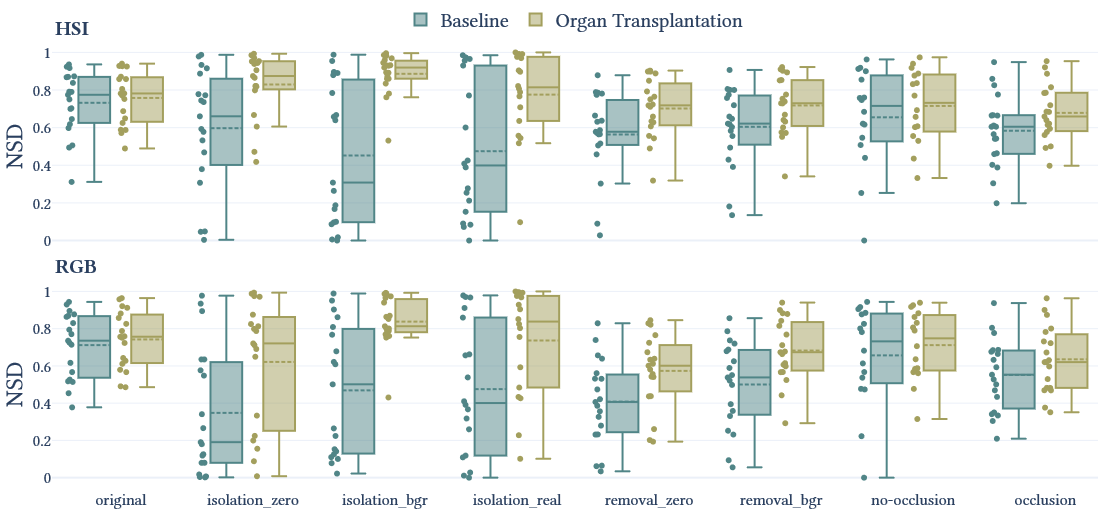

In [4]:
fig = dataset_comparison(settings_seg.nsd_aggregation_short)
fig.update_yaxes(title="NSD")
fig.write_image(settings_context.paper_dir / "task_performance_NSD.pdf")
fig

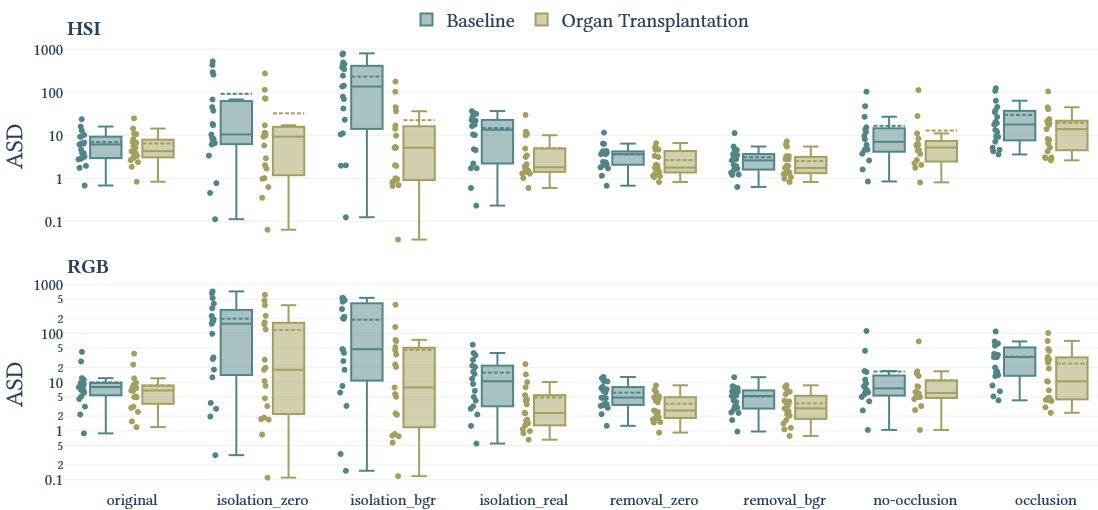

In [5]:
fig = dataset_comparison("surface_distance_metric")
fig.update_yaxes(type="log", range=None)
fig.update_yaxes(title="ASD")

## Modality Comparison

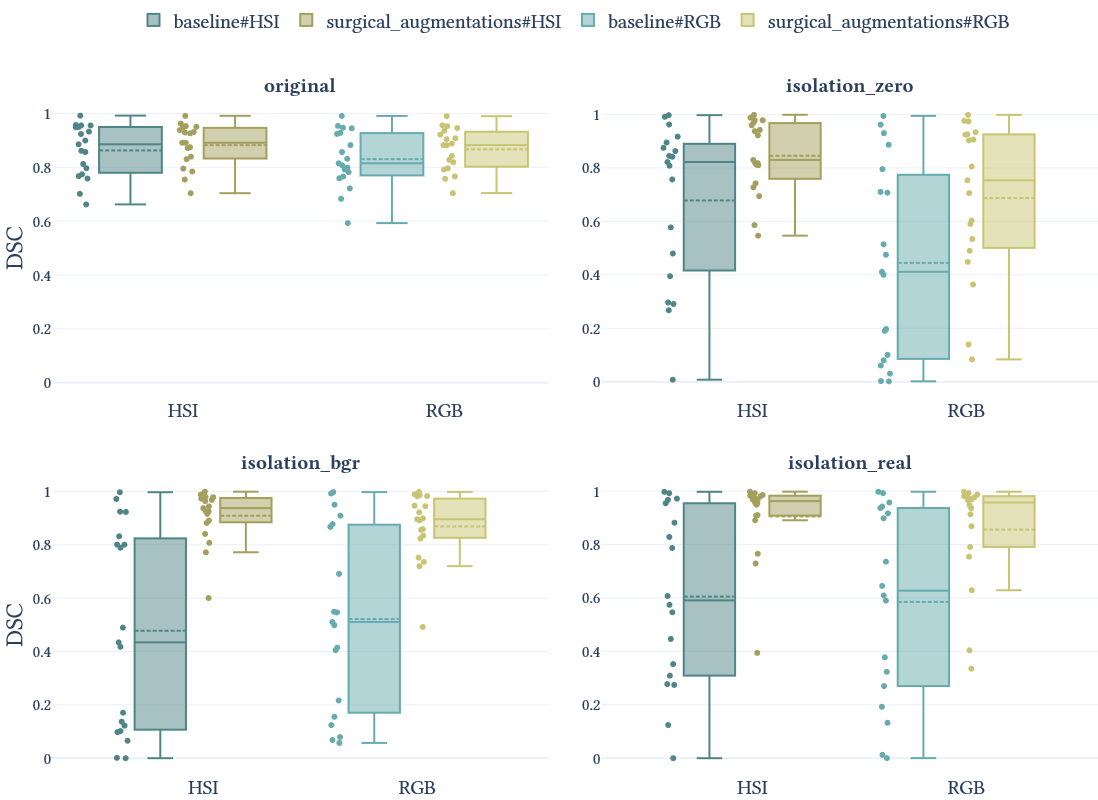

In [6]:
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=["<b>original</b>", "<b>isolation_zero</b>", "<b>isolation_bgr</b>", "<b>isolation_real</b>"],
    horizontal_spacing=0.05,
    vertical_spacing=0.12,
)

network_names = {
    "baseline": "baseline",
    "organ_transplantation": "surgical_augmentations",
}


def add_boxplot(fig: go.Figure, dataset: str, row: int, col: int) -> go.Figure:
    for i, series in df[["network", "modality"]].drop_duplicates().iterrows():
        network = series["network"]
        modality = series["modality"]
        name = network_names[network] + "#" + modality
        df_s = df.query("dataset == @dataset and network == @network and modality == @modality")
        fig.add_trace(
            go.Box(
                y=df_s["dice_metric"],
                x=[modality] * len(df_s["dice_metric"]),
                offsetgroup=network,
                text=df_s["label_name"],
                boxpoints="all",
                boxmean=True,
                name=name,
                marker_color=settings_context.network_colors[name],
                legendgroup=name,
                showlegend=row == 1 and col == 1,
            ),
            row=row,
            col=col,
        )

    return fig


fig = add_boxplot(fig, "semantic", row=1, col=1)
fig = add_boxplot(fig, "isolation_0", row=1, col=2)
fig = add_boxplot(fig, "isolation_cloth", row=2, col=1)
fig = add_boxplot(fig, "masks_isolation", row=2, col=2)

# Font size for subplot titles
for i in fig["layout"]["annotations"]:
    i["font"] = dict(size=20)

fig.update_yaxes(title="DSC", title_standoff=15, col=1)
fig.update_yaxes(tickfont=dict(size=16))
fig.update_layout(boxmode="group", boxgap=0.2, boxgroupgap=0.4)
fig.update_layout(yaxis_range=[-0.05, 1.05], xaxis_range=[-0.5, 1.4])
fig.update_layout(legend=dict(title=None, orientation="h", yanchor="bottom", y=1.09, xanchor="center", x=0.5))
fig.update_layout(
    template="plotly_white",
    height=800,
    width=1100,
    font_family="Libertinus Serif",
    font_size=20,
    margin=dict(l=0, r=0, b=0, t=0),
)
fig.write_image(settings_context.paper_dir / "task_performance_modality.pdf")
fig